# Gender Bias Model

In [9]:
from dataclasses import dataclass
import enum

import numpy as np
import matplotlib.pyplot as plt

# your additional imports here

In [10]:
RNG = np.random.default_rng(seed=1)
# your additional global initialization here

## §2. Implementing initial model for the project

#### ANSWER

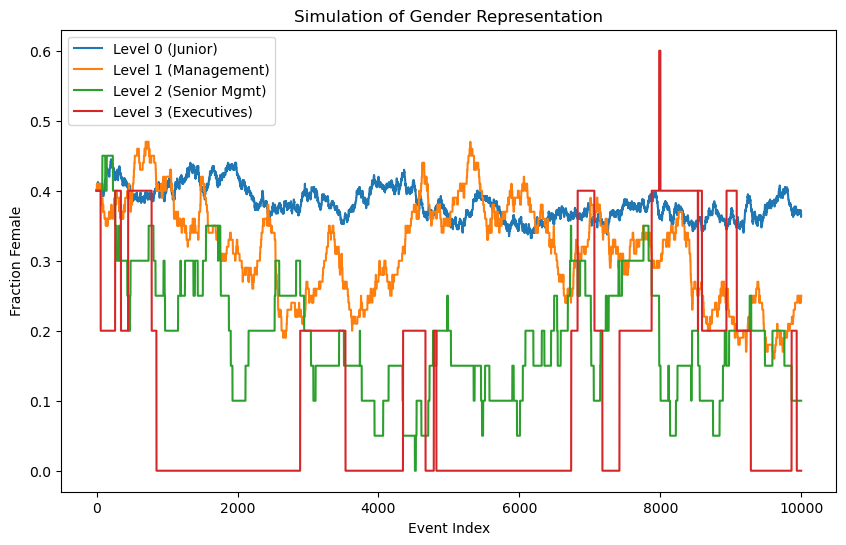

In [13]:
@dataclass(frozen=True)
class WorkplaceParams:
    """
    - n_l: number of employees at each level l=0,1,2,3
    - lambda_l_i: departure rates per employee (l=0..3, i in {F, M})
    - w0_f, w0_m: hiring weights for new level 0 employees
    - w(l)_f, w(l)_m for l=1..3: promotion weights from level (l-1) to level l
    """
    # Number of employees at each level
    n_0: int
    n_1: int
    n_2: int
    n_3: int
    
    # Departure rates: lambda_{l,F} and lambda_{l,M}
    lambda_0_f: float
    lambda_0_m: float
    lambda_1_f: float
    lambda_1_m: float
    lambda_2_f: float
    lambda_2_m: float
    lambda_3_f: float
    lambda_3_m: float
    
    # Hiring weights: w_{0,F} and w_{0,M}
    w0_f: float
    w0_m: float
    
    # Promotion weights: w_{l,F} and w_{l,M} for l=1,2,3
    w1_f: float
    w1_m: float
    w2_f: float
    w2_m: float
    w3_f: float
    w3_m: float


@dataclass(frozen=True)
class SimpleWorkplaceState:
    """
    Represents the current state of the workplace:
    - n_female_l: number of female employees at level l (l=0..3).
      The male count at level l is then (n_l - n_female_l).
    """
    n_female_0: int
    n_female_1: int
    n_female_2: int
    n_female_3: int


@dataclass
class SimpleWorkplaceModel:
    params: WorkplaceParams

    def transition_rate(self, state: SimpleWorkplaceState) -> float:
        """
        Sum of departure rates across levels & identities:
        R(state) = sum_{l in [0..3], i in {F,M}} lambda_{l,i} * count_{l,i}.
        """
        p = self.params
        f0, f1, f2, f3 = state.n_female_0, state.n_female_1, state.n_female_2, state.n_female_3
        
        m0 = p.n_0 - f0
        m1 = p.n_1 - f1
        m2 = p.n_2 - f2
        m3 = p.n_3 - f3
        
        rate = (
            p.lambda_0_f * f0 + p.lambda_0_m * m0 +
            p.lambda_1_f * f1 + p.lambda_1_m * m1 +
            p.lambda_2_f * f2 + p.lambda_2_m * m2 +
            p.lambda_3_f * f3 + p.lambda_3_m * m3
        )
        return rate

    def sample_next(self, state: SimpleWorkplaceState) -> SimpleWorkplaceState:
        """
        Samples a single departure event, then immediately hires or promotes
        to fill the vacancy. Returns the new state.
        """
        p = self.params
        
        # Current female counts
        f0 = state.n_female_0
        f1 = state.n_female_1
        f2 = state.n_female_2
        f3 = state.n_female_3
        
        # Current male counts
        m0 = p.n_0 - f0
        m1 = p.n_1 - f1
        m2 = p.n_2 - f2
        m3 = p.n_3 - f3
        
        # Departure rates for each sub-population
        r0F = p.lambda_0_f * f0
        r0M = p.lambda_0_m * m0
        r1F = p.lambda_1_f * f1
        r1M = p.lambda_1_m * m1
        r2F = p.lambda_2_f * f2
        r2M = p.lambda_2_m * m2
        r3F = p.lambda_3_f * f3
        r3M = p.lambda_3_m * m3
        
        R_total = r0F + r0M + r1F + r1M + r2F + r2M + r3F + r3M
        if R_total <= 1e-15:
            # No events possible
            return state
        
        # Inverse transform sampling
        u = RNG.random() * R_total
        
        def do_departure(level: int, is_female: bool, st: SimpleWorkplaceState) -> SimpleWorkplaceState:
            """
            Removes 1 employee from (level, identity), then hires or promotes.
            """
            sf0, sf1, sf2, sf3 = st.n_female_0, st.n_female_1, st.n_female_2, st.n_female_3
            
            # Decrement one from the departing subgroup
            if level == 0 and is_female: 
                sf0 -= 1
            elif level == 1 and is_female:
                sf1 -= 1
            elif level == 2 and is_female:
                sf2 -= 1
            elif level == 3 and is_female:
                sf3 -= 1
            # If is_female == False, the male count is implicitly decremented
            
            # Fill vacancy
            if level == 0:
                # Hire a new level-0 employee
                denom = p.w0_f + p.w0_m
                if denom > 1e-15:
                    p_female_hire = p.w0_f / denom
                    if RNG.random() < p_female_hire:
                        sf0 += 1
            else:
                # Promote from level-1
                if level == 1:
                    denom_0 = p.w1_f * sf0 + p.w1_m * (p.n_0 - sf0)
                    if denom_0 > 1e-15:
                        p_f = (p.w1_f * sf0) / denom_0
                        if RNG.random() < p_f:
                            sf0 -= 1
                            sf1 += 1
                elif level == 2:
                    denom_1 = p.w2_f * sf1 + p.w2_m * (p.n_1 - sf1)
                    if denom_1 > 1e-15:
                        p_f = (p.w2_f * sf1) / denom_1
                        if RNG.random() < p_f:
                            sf1 -= 1
                            sf2 += 1
                elif level == 3:
                    denom_2 = p.w3_f * sf2 + p.w3_m * (p.n_2 - sf2)
                    if denom_2 > 1e-15:
                        p_f = (p.w3_f * sf2) / denom_2
                        if RNG.random() < p_f:
                            sf2 -= 1
                            sf3 += 1
            
            return SimpleWorkplaceState(sf0, sf1, sf2, sf3)
        
        c = 0.0
        for (lvl, is_f, rate) in [
            (0, True, r0F), (0, False, r0M),
            (1, True, r1F), (1, False, r1M),
            (2, True, r2F), (2, False, r2M),
            (3, True, r3F), (3, False, r3M),
        ]:
            if c <= u < c + rate:
                return do_departure(lvl, is_f, state)
            c += rate
        
        # Fallback (rare floating error edge case)
        return do_departure(3, False, state)


def run_ctmc(model: SimpleWorkplaceModel, 
             state_init: SimpleWorkplaceState, 
             n_events: int = 10_000, 
             collect_stats: bool = True):
    """
    Simulate the CTMC by generating `n_events` departure events. 
    Each departure triggers an immediate hire/promotion.
    Returns either a list of states (if collect_stats=True) or just the final state.
    """
    states = []
    current_state = state_init
    
    for _ in range(n_events):
        states.append(current_state)
        current_state = model.sample_next(current_state)
        
    # Append the final state
    states.append(current_state)
    
    if collect_stats:
        return states
    else:
        return current_state


def main_example():
    # Create model parameters
    params = WorkplaceParams(
        n_0=400, n_1=100, n_2=20, n_3=5,
        lambda_0_f=0.01, lambda_0_m=0.01,
        lambda_1_f=0.01, lambda_1_m=0.01,
        lambda_2_f=0.01, lambda_2_m=0.01,
        lambda_3_f=0.01, lambda_3_m=0.01,
        w0_f=1.0, w0_m=1.1,  # equal hiring weights
        w1_f=1.0, w1_m=1.1,
        w2_f=1.0, w2_m=1.2,
        w3_f=1.0, w3_m=1.2
    )
    
    # Initial state: half employees at each level are female
    initial_state = SimpleWorkplaceState(
        n_female_0=160,
        n_female_1=40,
        n_female_2=8,
        n_female_3=2
    )
    
    model = SimpleWorkplaceModel(params)
    
    # Simulate
    states_path = run_ctmc(model, initial_state, n_events=10_000, collect_stats=True)
    
    # Gather stats
    female_props_0 = []
    female_props_1 = []
    female_props_2 = []
    female_props_3 = []
    
    for s in states_path:
        female_props_0.append(s.n_female_0 / params.n_0)
        female_props_1.append(s.n_female_1 / params.n_1)
        female_props_2.append(s.n_female_2 / params.n_2)
        female_props_3.append(s.n_female_3 / params.n_3)
    
    # Plot the fraction of female employees at each level
    plt.figure(figsize=(10,6))
    plt.plot(female_props_0, label="Level 0 (Junior)")
    plt.plot(female_props_1, label="Level 1 (Management)")
    plt.plot(female_props_2, label="Level 2 (Senior Mgmt)")
    plt.plot(female_props_3, label="Level 3 (Executives)")
    plt.xlabel("Event Index")
    plt.ylabel("Fraction Female")
    plt.title("Simulation of Gender Representation")
    plt.legend()
    plt.show()


main_example()


## §3. Implementing a more extensible model for the project

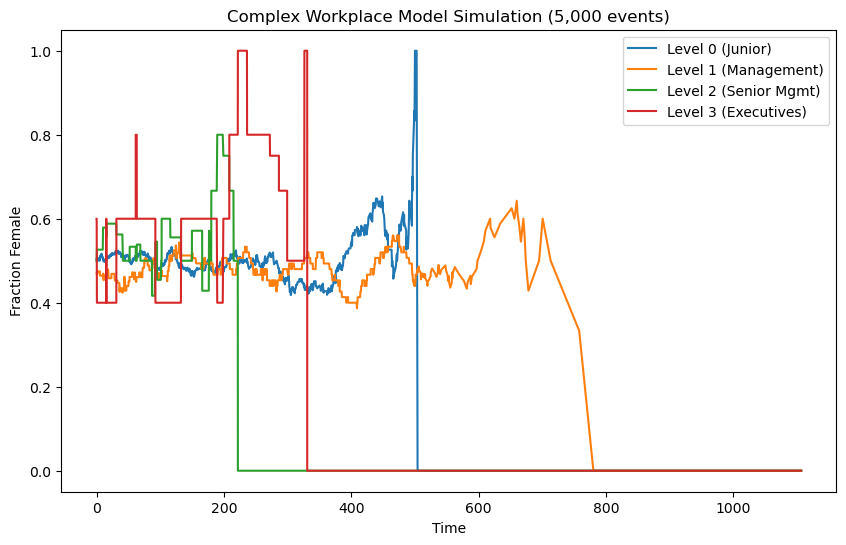

In [14]:
RNG = np.random.default_rng(seed=42)

# --------------------------------------------------------------------
# 1) Identity and Employee classes
# --------------------------------------------------------------------

class Identity(enum.Enum):
    FEMALE = enum.auto()
    MALE = enum.auto()

@dataclass(frozen=True)
class Employee:
    """
    Represents a single employee.
    
    Attributes
    ----------
    identity : Identity
        The employee's gender or other identity categories.

    hiring_and_promotion_times : tuple[float, ...]
        A tuple of times. The length of this tuple is the employee's current level+1.
        - The 0th element is the time they were hired at level 0.
        - The 1st element is the time they were promoted to level 1 (if any).
        - The 2nd element is time they were promoted to level 2, etc.
    """
    identity: Identity
    hiring_and_promotion_times: tuple[float, ...]

    @property
    def level(self) -> int:
        """
        The employee's current level: 0-based.
        If hiring_and_promotion_times has length k, then the employee is level (k-1).
        """
        return len(self.hiring_and_promotion_times) - 1

    @property
    def current_level_time(self) -> float:
        """
        The time at which the employee started at their current level.
        """
        return self.hiring_and_promotion_times[-1]

    @staticmethod
    def sample_new_hire(p_female: float, t_now: float):
        """
        Create a new level-0 employee object, hired at time t_now,
        with identity chosen by p_female vs. 1-p_female.
        """
        i = Identity.FEMALE if RNG.random() < p_female else Identity.MALE
        return Employee(i, (t_now,))

    def promoted(self, t_now: float):
        """
        Return a new Employee object representing the same person 
        after being promoted to the next level at time t_now.
        """
        return Employee(
            self.identity,
            (*self.hiring_and_promotion_times, t_now),
        )

# --------------------------------------------------------------------
# 2) ComplexWorkplaceState
# --------------------------------------------------------------------

@dataclass(frozen=True)
class ComplexWorkplaceState:
    employees_0: tuple[Employee, ...]
    employees_1: tuple[Employee, ...]
    employees_2: tuple[Employee, ...]
    employees_3: tuple[Employee, ...]

    def to_simple_state(self):
        """
        Convert to a SimpleWorkplaceState (count-based) if you want aggregated statistics.
        """
        from math import prod  # just a placeholder if needed
        n_f0 = sum(1 for e in self.employees_0 if e.identity == Identity.FEMALE)
        n_f1 = sum(1 for e in self.employees_1 if e.identity == Identity.FEMALE)
        n_f2 = sum(1 for e in self.employees_2 if e.identity == Identity.FEMALE)
        n_f3 = sum(1 for e in self.employees_3 if e.identity == Identity.FEMALE)
        return SimpleWorkplaceState(n_f0, n_f1, n_f2, n_f3)

    def count_at_level(self, lvl: int) -> int:
        """
        Convenience method: how many employees are at level `lvl`.
        """
        if lvl == 0:
            return len(self.employees_0)
        elif lvl == 1:
            return len(self.employees_1)
        elif lvl == 2:
            return len(self.employees_2)
        elif lvl == 3:
            return len(self.employees_3)
        else:
            raise ValueError("Level must be in {0,1,2,3}.")

    def remove_employee(self, lvl: int, emp_index: int):
        """
        Return a new ComplexWorkplaceState with the emp_index-th employee in level `lvl` removed.
        """
        if lvl == 0:
            new_0 = tuple(e for i, e in enumerate(self.employees_0) if i != emp_index)
            return ComplexWorkplaceState(new_0, self.employees_1, self.employees_2, self.employees_3)
        elif lvl == 1:
            new_1 = tuple(e for i, e in enumerate(self.employees_1) if i != emp_index)
            return ComplexWorkplaceState(self.employees_0, new_1, self.employees_2, self.employees_3)
        elif lvl == 2:
            new_2 = tuple(e for i, e in enumerate(self.employees_2) if i != emp_index)
            return ComplexWorkplaceState(self.employees_0, self.employees_1, new_2, self.employees_3)
        elif lvl == 3:
            new_3 = tuple(e for i, e in enumerate(self.employees_3) if i != emp_index)
            return ComplexWorkplaceState(self.employees_0, self.employees_1, self.employees_2, new_3)
        else:
            raise ValueError("Level must be in {0,1,2,3}.")

    def add_employee(self, lvl: int, e: Employee):
        """
        Return a new ComplexWorkplaceState with employee `e` added to level `lvl`.
        """
        if lvl == 0:
            new_0 = (*self.employees_0, e)
            return ComplexWorkplaceState(new_0, self.employees_1, self.employees_2, self.employees_3)
        elif lvl == 1:
            new_1 = (*self.employees_1, e)
            return ComplexWorkplaceState(self.employees_0, new_1, self.employees_2, self.employees_3)
        elif lvl == 2:
            new_2 = (*self.employees_2, e)
            return ComplexWorkplaceState(self.employees_0, self.employees_1, new_2, self.employees_3)
        elif lvl == 3:
            new_3 = (*self.employees_3, e)
            return ComplexWorkplaceState(self.employees_0, self.employees_1, self.employees_2, new_3)
        else:
            raise ValueError("Level must be in {0,1,2,3}.")


@dataclass(frozen=True)
class SimpleWorkplaceState:
    """
    The simpler 'counts-only' state that we used previously.
    """
    n_female_0: int
    n_female_1: int
    n_female_2: int
    n_female_3: int

# --------------------------------------------------------------------
# 3) ComplexWorkplaceModel
# --------------------------------------------------------------------

@dataclass
class ComplexWorkplaceModel:
    params: "WorkplaceParams"  # using the same parameters as before

    def transition_rate(self, state: ComplexWorkplaceState) -> float:
        """
        The total departure rate = sum_{employee} lambda_{employee.level, employee.identity}.
        If level=0 and identity=F, use lambda_0_f, etc.
        """
        p = self.params
        rate = 0.0

        # level 0
        for e in state.employees_0:
            if e.identity == Identity.FEMALE:
                rate += p.lambda_0_f
            else:
                rate += p.lambda_0_m
        
        # level 1
        for e in state.employees_1:
            if e.identity == Identity.FEMALE:
                rate += p.lambda_1_f
            else:
                rate += p.lambda_1_m
        
        # level 2
        for e in state.employees_2:
            if e.identity == Identity.FEMALE:
                rate += p.lambda_2_f
            else:
                rate += p.lambda_2_m
        
        # level 3
        for e in state.employees_3:
            if e.identity == Identity.FEMALE:
                rate += p.lambda_3_f
            else:
                rate += p.lambda_3_m

        return rate

    def sample_next(self, state: ComplexWorkplaceState, t_now: float):
        """
        Perform one departure event in the CTMC:
         1) sample the time to next event dt ~ Exp(R_total).
         2) pick which specific employee departs (weighted by their departure rate).
         3) fill the vacancy by either new hire (if level=0) or promote from level-1 (if level>0).
        Returns (new_state, t_next).
        """
        R_total = self.transition_rate(state)
        if R_total < 1e-15:
            # No one can leave -> no transition
            return state, t_now
        
        # 1) Sample time to next departure
        dt = np.random.exponential(1.0 / R_total)
        t_next = t_now + dt
        
        # 2) Pick which employee departs
        # We'll build a list of (level, emp_index, departure_rate).
        departure_list = []
        
        p = self.params
        # level 0
        for idx, e in enumerate(state.employees_0):
            r = p.lambda_0_f if e.identity == Identity.FEMALE else p.lambda_0_m
            departure_list.append((0, idx, r))
        # level 1
        for idx, e in enumerate(state.employees_1):
            r = p.lambda_1_f if e.identity == Identity.FEMALE else p.lambda_1_m
            departure_list.append((1, idx, r))
        # level 2
        for idx, e in enumerate(state.employees_2):
            r = p.lambda_2_f if e.identity == Identity.FEMALE else p.lambda_2_m
            departure_list.append((2, idx, r))
        # level 3
        for idx, e in enumerate(state.employees_3):
            r = p.lambda_3_f if e.identity == Identity.FEMALE else p.lambda_3_m
            departure_list.append((3, idx, r))
        
        # Weighted random choice
        u = RNG.random() * R_total
        cumulative = 0.0
        chosen_level = None
        chosen_index = None
        
        for (lvl, idx, rate) in departure_list:
            if cumulative <= u < cumulative + rate:
                chosen_level = lvl
                chosen_index = idx
                break
            cumulative += rate
        
        # Fallback in case of rounding errors
        if chosen_level is None:
            chosen_level = departure_list[-1][0]
            chosen_index = departure_list[-1][1]
        
        # 3) Fill the vacancy
        # Remove departing employee
        new_state = state.remove_employee(chosen_level, chosen_index)

        # If departure is from level=0, hire new:
        if chosen_level == 0:
            denom = p.w0_f + p.w0_m
            if denom < 1e-15:
                # Edge case: can't hire female or male => do nothing
                pass
            else:
                p_female = p.w0_f / denom
                hired_emp = Employee.sample_new_hire(p_female, t_next)
                new_state = new_state.add_employee(0, hired_emp)
        
        else:
            # Need to promote from (chosen_level - 1)
            L = chosen_level  # the vacancy at level L
            from_level = L - 1
            # Probability of picking a female from from_level:
            employees_from = (
                new_state.employees_0 if from_level == 0 else
                new_state.employees_1 if from_level == 1 else
                new_state.employees_2 if from_level == 2 else
                new_state.employees_3
            )
            count_f = sum(e.identity == Identity.FEMALE for e in employees_from)
            count_m = sum(e.identity == Identity.MALE for e in employees_from)
            
            if from_level == 0:
                w_f = p.w1_f
                w_m = p.w1_m
            elif from_level == 1:
                w_f = p.w2_f
                w_m = p.w2_m
            elif from_level == 2:
                w_f = p.w3_f
                w_m = p.w3_m
            else:
                raise ValueError("No promotion from level 3")

            # Weighted probability that the promotee is female:
            total_weight = w_f*count_f + w_m*count_m
            if total_weight < 1e-15:
                # Edge case: no employees or zero weights, can't promote
                pass
            else:
                u2 = RNG.random() * total_weight
                # Decide identity for promotee
                if u2 < w_f * count_f:
                    promote_identity = Identity.FEMALE
                else:
                    promote_identity = Identity.MALE
                
                # Among employees of the chosen identity, pick uniformly
                from_list = list(employees_from)  # make it mutable
                
                # Gather indices of employees of that identity
                cand_indices = [i for i,e in enumerate(from_list) if e.identity == promote_identity]
                if cand_indices:
                    chosen_emp_idx = RNG.choice(cand_indices)
                    chosen_emp = from_list[chosen_emp_idx]
                    
                    # Remove them from the old level
                    new_state = new_state.remove_employee(from_level, chosen_emp_idx)
                    # Create the promoted version
                    promoted_emp = chosen_emp.promoted(t_next)
                    # Add them to the vacancy level
                    new_state = new_state.add_employee(L, promoted_emp)
        
        return new_state, t_next

# --------------------------------------------------------------------
# 4) Example "run_ctmc_complex" function
# --------------------------------------------------------------------

def run_ctmc_complex(model: ComplexWorkplaceModel, 
                     initial_state: ComplexWorkplaceState,
                     t_start=0.0, 
                     n_events=10_000):
    """
    Simulate the CTMC for `n_events` departure events, returning a list of (time, state).
    """
    t_now = t_start
    state_now = initial_state
    path = [(t_now, state_now)]
    
    for _ in range(n_events):
        new_state, t_next = model.sample_next(state_now, t_now)
        path.append((t_next, new_state))
        t_now = t_next
        state_now = new_state
    
    return path

# --------------------------------------------------------------------
# 5) Demo usage
# --------------------------------------------------------------------

@dataclass(frozen=True)
class WorkplaceParams:
    """
    Same structure as our simpler model’s parameters, now reused for the ComplexWorkplaceModel.
    """
    n_0: int
    n_1: int
    n_2: int
    n_3: int
    
    lambda_0_f: float
    lambda_0_m: float
    lambda_1_f: float
    lambda_1_m: float
    lambda_2_f: float
    lambda_2_m: float
    lambda_3_f: float
    lambda_3_m: float
    
    w0_f: float
    w0_m: float
    
    w1_f: float
    w1_m: float
    w2_f: float
    w2_m: float
    w3_f: float
    w3_m: float


def main_example_complex():
    # 1) Define parameters
    params = WorkplaceParams(
        n_0=400, n_1=100, n_2=20, n_3=5, 
        lambda_0_f=0.01, lambda_0_m=0.01,
        lambda_1_f=0.01, lambda_1_m=0.01,
        lambda_2_f=0.01, lambda_2_m=0.01,
        lambda_3_f=0.01, lambda_3_m=0.01,
        w0_f=1.0, w0_m=1.0,
        w1_f=1.0, w1_m=1.0,
        w2_f=1.0, w2_m=1.0,
        w3_f=1.0, w3_m=1.0
    )
    
    model = ComplexWorkplaceModel(params=params)
    
    # 2) Build an initial state with random hires at time=0
    def random_employee(p_female=0.5, t_now=0.0):
        return Employee.sample_new_hire(p_female, t_now)
    
    employees_0 = tuple(random_employee(0.5, 0.0) for _ in range(params.n_0))
    employees_1 = tuple(random_employee(0.5, 0.0) for _ in range(params.n_1))
    employees_2 = tuple(random_employee(0.5, 0.0) for _ in range(params.n_2))
    employees_3 = tuple(random_employee(0.5, 0.0) for _ in range(params.n_3))
    
    initial_state = ComplexWorkplaceState(employees_0, employees_1, employees_2, employees_3)
    
    # 3) Run the simulation
    path = run_ctmc_complex(model, initial_state, t_start=0.0, n_events=5000)
    
    # 4) Convert path states to "SimpleWorkplaceState" for plotting
    times = []
    frac_f0 = []
    frac_f1 = []
    frac_f2 = []
    frac_f3 = []

    for (t, st) in path:
        ss = st.to_simple_state()
        denom_0 = len(st.employees_0)
        denom_1 = len(st.employees_1)
        denom_2 = len(st.employees_2)
        denom_3 = len(st.employees_3)
        
        frac_f0.append(ss.n_female_0 / denom_0 if denom_0>0 else 0)
        frac_f1.append(ss.n_female_1 / denom_1 if denom_1>0 else 0)
        frac_f2.append(ss.n_female_2 / denom_2 if denom_2>0 else 0)
        frac_f3.append(ss.n_female_3 / denom_3 if denom_3>0 else 0)
        
        times.append(t)
    
    # 5) Plot the fraction of female employees over time
    plt.figure(figsize=(10,6))
    plt.plot(times, frac_f0, label="Level 0 (Junior)")
    plt.plot(times, frac_f1, label="Level 1 (Management)")
    plt.plot(times, frac_f2, label="Level 2 (Senior Mgmt)")
    plt.plot(times, frac_f3, label="Level 3 (Executives)")
    plt.xlabel("Time")
    plt.ylabel("Fraction Female")
    plt.title("Complex Workplace Model Simulation (5,000 events)")
    plt.legend()
    plt.show()

main_example_complex()
